In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [2]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Using device: cuda


In [3]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_7.5s_0.05s.pt')
target_tensors = torch.load('target_tensors_7.5s_0.05s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([150, 22])
Shape of target tensor: torch.Size([3000])


In [4]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [5]:
# Normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# Make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_std

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
input_size = len(train_dataset[0][0][0])  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
# model.load_state_dict(torch.load('model_weights_7.5s_0.05s.pt'))

# at 3250 total so far
num_epochs = 5_000

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)

        prev_loss = average_loss


Epoch 5000, Loss: 0.5509: 100%|██████████| 5000/5000 [15:05<00:00,  5.52it/s] 


In [8]:
model.load_state_dict(torch.load('model_weights_7.5s_0.05s.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_7.5s_0.05s.pt'

In [9]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_7.5s_0.05s.pt')

In [10]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total absolute error
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.24895834116556215


In [11]:
# Initialize variables to calculate total absolute error for denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value and denormalize it
        predicted_value = denormalize(model(input_tensor).item())
        actual_value = denormalize(target_value.item())

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 28.070106506347656


In [12]:
# Initialize list to store absolute errors
absolute_errors = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error and append to list
        absolute_error = abs(predicted_value - actual_value)
        absolute_errors.append(absolute_error)

# Calculate median absolute error
median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.029353126883506775


In [13]:
# get the median absolute error for the denormalized values
absolute_errors = []

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 3.3095712661743164


In [14]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0).to(device)).item()
    actual_value = test_targets[i].to(device).item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.9356029679901635


In [15]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 11893.951171875


In [16]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].to(device).unsqueeze(0)).item()
    actual_value = test_targets[i].to(device).item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.2571905851364136, Predicted: -0.27593421936035156
Actual: -0.24945491552352905, Predicted: -0.22178351879119873
Actual: -0.2573663890361786, Predicted: -0.26752424240112305
Actual: -0.0890507772564888, Predicted: -0.11444377899169922
Actual: -0.2573193311691284, Predicted: -0.2729206085205078
Actual: -0.19357086718082428, Predicted: -0.22012639045715332
Actual: -0.23657523095607758, Predicted: -0.2656064033508301
Actual: -0.2164585441350937, Predicted: -0.23184621334075928
Actual: -0.2203672230243683, Predicted: -0.2503918409347534
Actual: -0.2505798935890198, Predicted: -0.19737577438354492
Actual: -0.19132943451404572, Predicted: -0.19013023376464844
Actual: -0.22837667167186737, Predicted: -0.2766764163970947
Actual: -0.25420093536376953, Predicted: -0.10421276092529297
Actual: -0.23093992471694946, Predicted: -0.2434248924255371
Actual: -0.1291169971227646, Predicted: -0.22171664237976074
Actual: -0.24234522879123688, Predicted: -0.2667267322540283
Actual: -0.09662577509

In [17]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: 0.42946815490722656, Predicted: -1.6838798522949219
Actual: 1.301666259765625, Predicted: 4.421621322631836
Actual: 0.40964508056640625, Predicted: -0.7356548309326172
Actual: 19.387264251708984, Predicted: 16.524198532104492
Actual: 0.4149513244628906, Predicted: -1.344095230102539
Actual: 7.602603912353516, Predicted: 4.608463287353516
Actual: 2.7538528442382812, Predicted: -0.5194168090820312
Actual: 5.022012710571289, Predicted: 3.287050247192383
Actual: 4.581308364868164, Predicted: 1.1960277557373047
Actual: 1.1748237609863281, Predicted: 7.1735992431640625
Actual: 7.855325698852539, Predicted: 7.990535736083984
Actual: 3.678241729736328, Predicted: -1.7675628662109375
Actual: 0.7665519714355469, Predicted: 17.67774772644043
Actual: 3.3892345428466797, Predicted: 1.9815521240234375
Actual: 14.869790077209473, Predicted: 4.429161071777344
Actual: 2.1032848358154297, Predicted: -0.6457347869873047
Actual: 18.53318214416504, Predicted: 9.114233016967773
Actual: 41.8598403930

In [18]:
# Calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")

# Print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 176.10816506730873%
Standard Deviation of Percentage Errors: 13.609665644370239
Average Percentage Error (Without Top 2%): 53.76587677001953%
Standard Deviation of Percentage Errors (Without Top 2%): 13.745916011901604


In [19]:
# Calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# Print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors for denormalized values (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")


Average Percentage Error (Denormalized): 321.3256530761719%
Standard Deviation of Percentage Errors (Denormalized): 9.235580444335938
Average Percentage Error (Without Top 2%, Denormalized): 53.76587677001953%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 9.276451110839844


In [20]:
# Calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 13.646468882162882%


In [21]:
# Calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")


Median Percentage Error (Denormalized): 90.66975116729736%


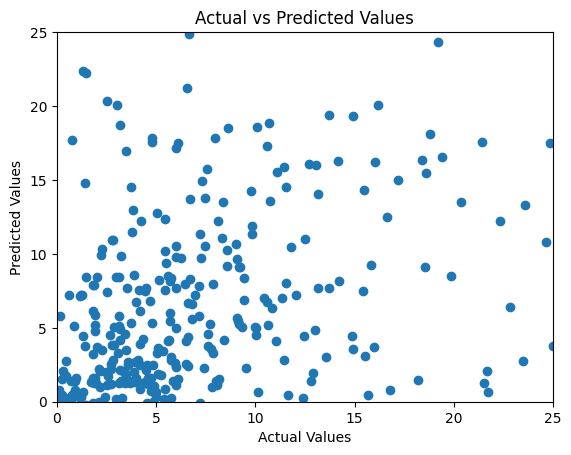

In [22]:
# Plot the denormalized values for the actual and predicted values on the testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()
